### Imports

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

import zipfile

import os
import re
from glob import glob
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab

from point_net import PointNetSegHead

import torch.optim as optim
from point_net_loss import PointNetSegLoss

from sklearn import metrics
from random import randrange




Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [19]:
runs_on = "Local" # or "Local" for testing purposes

### Downloading Dataset

Dataset: Sorghum Plants Labeled 3D LiDAR Point Cloud Data

Located at: https://data.mendeley.com/datasets/pfnfzrmrg7/1


### Loading the dataset

In [20]:
if runs_on == "Colab":
  from google.colab import drive
  drive.mount('/content/drive')

**SET the folder the zip file is stored**

Num of total samples = 502.

20% split (training / validation)

In [ ]:

if runs_on == "Colab": 
  data_dir = "/content/drive/My Drive/PointNet-Keras/Data/"
  models_dir = "/content/drive/My Drive/PointNet-Keras/models/"
  zipfilename = "Sorghum Plants Labeled 3D LiDAR Point Cloud Data.zip"
else: 
  data_dir = "C:\\Users\\nydor_pt\\MY-DOCUMENTS\\JIMMY\\UCD\\Jimmy-PHD\\Papers-Read\\3D PointCloud Datasets\\Sorghum_Plants\\"
  #zipfilename = "Short_Sorghum Plants Labeled 3D LiDAR Point Cloud Data.zip"
  #zipfilename = "dataset_short_25.zip"
  zipfilename = "Sorghum Plants Labeled 3D LiDAR Point Cloud Data.zip"

Some settings!

In [ ]:
npoints = 1000
# When full set then batch_size = 32 !!!!
# else batch_size = 8 !!!
batch_size = 32 # 8  
epochs = 2 # 100
model_name = "testing"

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)



categories = ["leaf", "stem", "panice"]
num_classes = len(categories)
features_used = 'xyz' #'xyzrgb'
valid_split = 0.2

'''
if runs_on == "Colab":
    n_train_samples = 490
else:
    n_train_samples = 20 #20

'''

Device:  cuda


'\nif runs_on == "Colab":\n    n_train_samples = 490\nelse:\n    n_train_samples = 20 #20\n\n'

## Structuring the dataset


In [24]:
def pc_normalize(pc):
    c = np.mean(pc, axis=0)
    pc = pc - c
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    pc = pc /m
    return pc

In [25]:
t_pointclouds = []
t_pointclouds_labels = []
test_pointclouds_labels = []
test_pointclouds = []

minpoints = 50000000

zf = zipfile.ZipFile(data_dir + zipfilename)
points_files = zf.infolist()

print ("Uncompressing and reading data... ")
i=1
for point_file in tqdm(points_files):
    #print(point_file.filename)

    if point_file.filename == "dataset_short/": 
        continue
    df = pd.read_csv(zf.open(point_file.filename), sep=" ", header=None)
    try:
        df.columns = ["x", "y", "z", "r", "g", "b", "l1", "l2"]
    except Exception as e: 
        # labeled_plant137.txt: has 9 columns. the last colmn has nan values
        #print("Cleaning the Exception for: \n")
        #print("File: ", point_file)
        #print(df.shape)  
        df = df.iloc[:,:-1] 
        df.columns = ["x", "y", "z", "r", "g", "b", "l1", "l2"]
        #print(e)
        
    #print(df.shape)
    if (df.shape[0]<minpoints):
        minpoints = df.shape[0]
    df['label1'] = np.where(df['l1'] == 0, 'leaf', np.where(df['l1'] == 1, 'stem', 'panice')) 
    
    if 'rgb' in features_used:
        pointcloud = df[["x", "y", "z", "r", "g", "b"]]
    else: 
        pointcloud = df[["x", "y", "z"]]
    
    pointcloud_labels = df['l1'].tolist()

    # Randomly sampling respective indices.
    choice = np.random.choice(len(pointcloud_labels), npoints, replace = True)
    # Resampling points corresponding to sampled indices.
    sampled_pointcloud = pointcloud.to_numpy()[choice, :]
    #sampled_pointcloud_labels = pointcloud_labels[choice]
    sampled_pointcloud_labels = np.array([pointcloud_labels[i] for i in choice])

    # Normalize 
    norm_pointcloud = pc_normalize(sampled_pointcloud)
    '''
    if i <= n_train_samples:
        t_pointclouds.append(norm_pointcloud)
        t_pointclouds_labels.append(sampled_pointcloud_labels)
    else:
        test_pointclouds.append(norm_pointcloud)
        test_pointclouds_labels.append(sampled_pointcloud_labels)
    '''
    t_pointclouds.append(norm_pointcloud)
    t_pointclouds_labels.append(sampled_pointcloud_labels)

    i = i + 1

    '''
    if i>5:
        break'
    '''
 



Uncompressing and reading data... 


100%|██████████| 26/26 [00:05<00:00,  4.97it/s]


In [26]:
# print minimum number of points in the samples
print(minpoints)

87293


In [27]:
print(len(t_pointclouds))
print(t_pointclouds[0].shape)
print(type(t_pointclouds[2]))

print(len(t_pointclouds_labels[0]))
print(len(t_pointclouds_labels))
print(type(t_pointclouds_labels))

'''
print(len(test_pointclouds))
print(test_pointclouds[0].shape)
print(type(test_pointclouds[2]))

print(len(test_pointclouds_labels[0]))
print(len(test_pointclouds_labels))
print(type(test_pointclouds_labels))
'''


25
(1000, 3)
<class 'numpy.ndarray'>
1000
25
<class 'list'>


'\nprint(len(test_pointclouds))\nprint(test_pointclouds[0].shape)\nprint(type(test_pointclouds[2]))\n\nprint(len(test_pointclouds_labels[0]))\nprint(len(test_pointclouds_labels))\nprint(type(test_pointclouds_labels))\n'

In [28]:
# split to training and validation pointclouds
split_index = int(len(t_pointclouds) * (1 - valid_split))
train_pointclouds = t_pointclouds[:split_index]
train_pointclouds_labels = t_pointclouds_labels[:split_index]

valid_pointclouds = t_pointclouds[split_index:]
valid_pointclouds_labels = t_pointclouds_labels[split_index:]

print("Num train point clouds:", len(train_pointclouds))
print("Num train point cloud labels:", len(train_pointclouds_labels))
print("Num validation point clouds:", len(valid_pointclouds))
print("Num validation point cloud labels:", len(valid_pointclouds_labels))
'''
print("Num test point clouds:", len(test_pointclouds))
print("Num test point cloud labels:", len(test_pointclouds_labels))
'''

Num train point clouds: 20
Num train point cloud labels: 20
Num validation point clouds: 5
Num validation point cloud labels: 5


'\nprint("Num test point clouds:", len(test_pointclouds))\nprint("Num test point cloud labels:", len(test_pointclouds_labels))\n'

### Visualize some data

In [29]:
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        0: [0, 0, 255], # blue
        1: [0, 128, 0], # green
        2: [255, 0, 0], # red
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

In [30]:
def visualize_data(pointcloud,pointcloud_labels):

    pcd = o3.geometry.PointCloud()
    pcd.points = o3.utility.Vector3dVector(pointcloud)
    pcd.colors = o3.utility.Vector3dVector(read_pointnet_colors(np.asarray(pointcloud_labels, dtype=np.float32)))

    o3.visualization.draw_plotly([pcd])

    # optional visualization for non Colab
    # draw(pcd)

In [31]:
idx = 5
visualize_data(train_pointclouds[idx],train_pointclouds_labels[idx])

In [32]:
# setup dataloaders
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(np.asarray(train_pointclouds, dtype=np.float32)), 
                                   torch.from_numpy(np.asarray(train_pointclouds_labels, dtype=np.float32)).type(torch.LongTensor)), 
    shuffle=True,
    batch_size=batch_size,
    **kwargs
)

kwargs = {'num_workers': 1, 'pin_memory': True}
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(np.asarray(valid_pointclouds, dtype=np.float32)), 
                                   torch.from_numpy(np.asarray(valid_pointclouds_labels, dtype=np.float32)).type(torch.LongTensor)), 
    shuffle=True,
    batch_size=batch_size,
    **kwargs
)
'''
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(np.asarray(test_pointclouds, dtype=np.float32)), 
                                   torch.from_numpy(np.asarray(test_pointclouds_labels, dtype=np.float32)).type(torch.LongTensor)), 
    shuffle=True,
    batch_size=batch_size,
    **kwargs
)
'''
print("Num train dataloader length:", len(train_loader.dataset))
print("Num valid dataloader length:", len(valid_loader.dataset))
#print("Num test dataloader length:", len(test_loader.dataset))

Num train dataloader length: 20
Num valid dataloader length: 5


### PointNet

In [33]:
def compute_iou(targets, predictions):

    targets = targets.reshape(-1)
    predictions = predictions.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union 

### Training parameters


**BE CAREFUL: Select another metric !!!**

Refer to 

https://medium.com/@sepideh.92sh/decoding-pointnet-a-practical-guide-to-3d-segmentation-with-python-and-pytorch-7a037fecb8a7

In [34]:
LR = 0.0001

alpha = np.ones(num_classes)
alpha[0:3] *= 0.25 # balance background classes
alpha[-1] *= 0.75  # balance clutter class

gamma = 1

seg_model = PointNetSegHead(num_points=npoints, m=num_classes)

criterion = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).to(device)

mcc_metric = MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
optimizer = optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-3, 
                                              step_size_up=1000, cycle_momentum=False)


seg_model = seg_model.to(device)

# store best validation iou
best_iou = 0.1


In [35]:
# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
train_iou = []
valid_loss = []
valid_accuracy = []
valid_mcc = []
valid_iou = []

# stuff for training
num_train_batch = int(np.ceil(len(train_loader.dataset)/batch_size))
num_valid_batch = int(np.ceil(len(valid_loader.dataset)/batch_size))

for epoch in range(1, epochs + 1):
    # place model in training mode
    seg_model = seg_model.train()
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    _train_iou = []
    
    for i, (points, targets) in enumerate(train_loader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, _ = seg_model(points)

        # get class predictions
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        # get loss and perform backprop
        loss = criterion(preds, targets, pred_choice)
   
        loss.backward()
        optimizer.step()
        scheduler.step() # update learning rate
        
        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(batch_size*npoints)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())
        _train_iou.append(iou.item())

        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_train_batch}] ' \
                  + f'train loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))
    train_iou.append(np.mean(_train_iou))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]:.4f} ' \
          + f'- Train Accuracy: {train_accuracy[-1]:.4f} ' \
          + f'- Train MCC: {train_mcc[-1]:.4f} ' \
          + f'- Train IOU: {train_iou[-1]:.4f}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        seg_model = seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        _valid_iou = []
        for i, (points, targets) in enumerate(valid_loader, 0):

            points = points.transpose(2, 1).to(device)
            targets = targets.squeeze().to(device)

            preds, _, A = seg_model(points)

            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

            loss = criterion(preds, targets, pred_choice) 


            # get metrics
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct/float(batch_size*npoints)
            mcc = mcc_metric(preds.transpose(2, 1), targets)
            iou = compute_iou(targets, pred_choice)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)
            _valid_mcc.append(mcc.item())
            _valid_iou.append(iou.item())

            if i % 100 == 0:
                print(f'\t [{epoch}: {i}/{num_valid_batch}] ' \
                  + f'valid loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} '
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        valid_iou.append(np.mean(_valid_iou))
        print(f'Epoch: {epoch} - Valid Loss: {valid_loss[-1]:.4f} ' \
              + f'- Valid Accuracy: {valid_accuracy[-1]:.4f} ' \
              + f'- Valid MCC: {valid_mcc[-1]:.4f} ' \
              + f'- Valid IOU: {valid_iou[-1]:.4f}')


        # pause to cool down
        time.sleep(4)

    # save best model
    if valid_iou[-1] >= best_iou:
        best_iou = valid_iou[-1]
        torch.save(seg_model.state_dict(), f'trained_models/{model_name}.pth')

    # if valid_mcc[-1] >= best_mcc:
    #     best_mcc = valid_mcc[-1]
    #     torch.save(seg_model.state_dict(), f'trained_models/seg_focal_dice_mcc/seg_model_{epoch}.pth')

c:\Users\nydor_pt\Desktop\Jimmy-PHD-Sources\testbed\PointNet\point_net_loss.py:82: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



	 [1: 0/3] train loss: 1.4345 accuracy: 0.3510 mcc: 0.0694 iou: 0.2129
Epoch: 1 - Train Loss: 1.4820 - Train Accuracy: 0.2541 - Train MCC: 0.0506 - Train IOU: 0.1827
	 [1: 0/1] valid loss: 1.6287 accuracy: 0.0830 mcc: 0.0000 iou: 0.0711
Epoch: 1 - Valid Loss: 1.6287 - Valid Accuracy: 0.0830 - Valid MCC: 0.0000 - Valid IOU: 0.0711
	 [2: 0/3] train loss: 1.4558 accuracy: 0.3413 mcc: 0.0419 iou: 0.2057
Epoch: 2 - Train Loss: 1.4749 - Train Accuracy: 0.2653 - Train MCC: 0.0078 - Train IOU: 0.1940
	 [2: 0/1] valid loss: 1.6255 accuracy: 0.0830 mcc: 0.0000 iou: 0.0711
Epoch: 2 - Valid Loss: 1.6255 - Valid Accuracy: 0.0830 - Valid MCC: 0.0000 - Valid IOU: 0.0711


### Plot

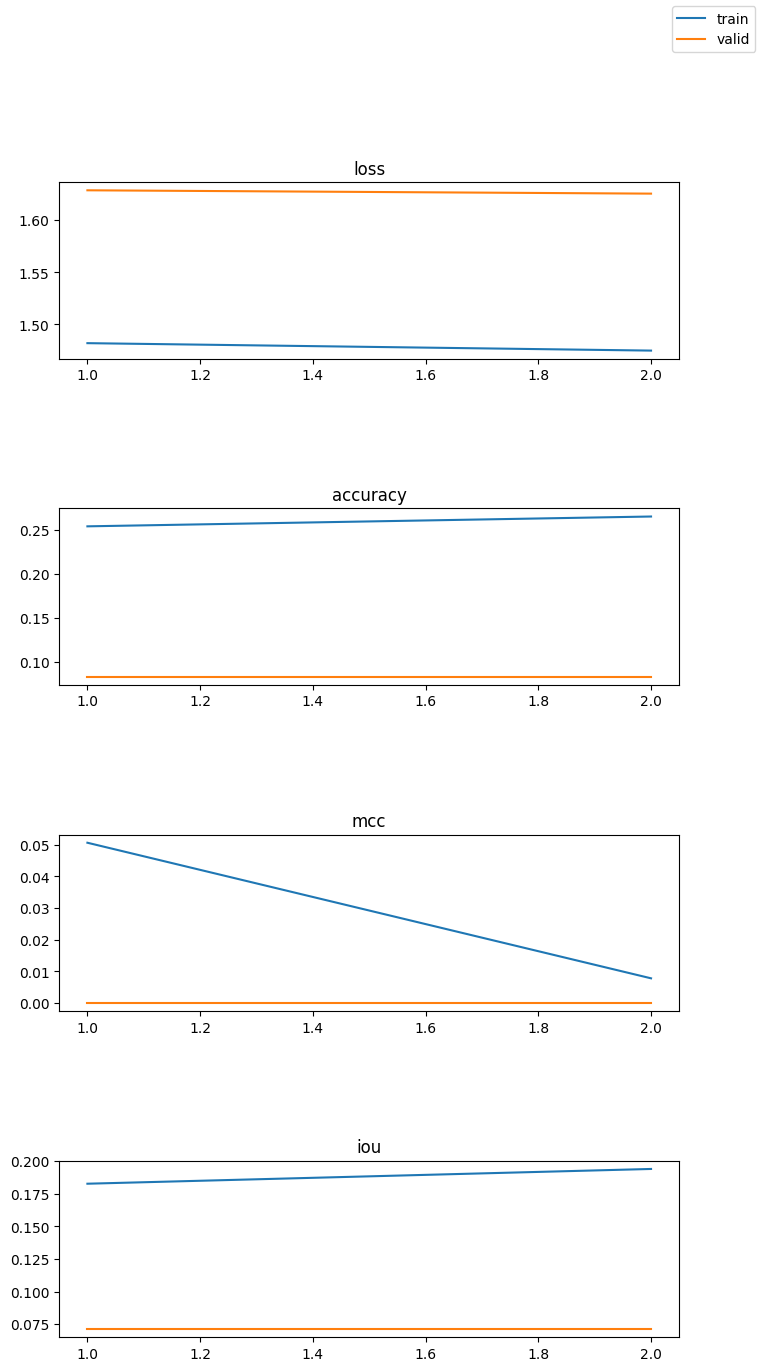

In [36]:
fig, ax = plt.subplots(4, 1, figsize=(8, 15))
ax[0].plot(np.arange(1, epochs + 1), train_loss, label='train')
ax[0].plot(np.arange(1, epochs + 1), valid_loss, label='valid')
ax[0].set_title('loss')

ax[1].plot(np.arange(1, epochs + 1), train_accuracy)
ax[1].plot(np.arange(1, epochs + 1), valid_accuracy)
ax[1].set_title('accuracy')

ax[2].plot(np.arange(1, epochs + 1), train_mcc)
ax[2].plot(np.arange(1, epochs + 1), valid_mcc)
ax[2].set_title('mcc')

ax[3].plot(np.arange(1, epochs + 1), train_iou)
ax[3].plot(np.arange(1, epochs + 1), valid_iou)
ax[3].set_title('iou')

fig.legend(loc='upper right')
plt.subplots_adjust(wspace=0., hspace=0.85)

### Test the model

!! Set MODELNAME

In [37]:
model_name = "testing"

MODEL_PATH = 'trained_models/' + model_name + '.pth'

model = PointNetSegHead(num_points=npoints, m=num_classes).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

PointNetSegHead(
  (backbone): PointNetBackbone(
    (tnet1): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (linear1): Linear(in_features=1024, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (linear3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pool): MaxPool1d(kernel_size=1000, stride=1000, padding=

SET dataloader for testing

In [38]:
test_loader = valid_loader

In [39]:
num_test_batch = int(np.ceil(len(test_loader.dataset)/batch_size))

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    test_iou = []
    for i, (points, targets) in enumerate(test_loader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)

        preds, _, A = model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        loss = criterion(preds, targets, pred_choice)

        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(batch_size*npoints)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())
        test_iou.append(iou.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print(f'\t [{i}/{num_test_batch}] ' \
                  + f'test loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
            
# display test results
print(f'Test Loss: {np.mean(test_loss):.4f} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy):.4f} ' \
        + f'- Test MCC: {np.mean(test_mcc):.4f} ' \
        + f'- Test IOU: {np.mean(test_iou):.4f}')

Precision = metrics.precision_score(total_test_targets, total_test_preds, average='micro')

Recall = metrics.recall_score(total_test_targets, total_test_preds, average='micro' )

F1_score = metrics.f1_score(total_test_targets, total_test_preds, average='micro')
print("Precision: ", Precision, " Recall: ", Recall, " F1 score: ", F1_score)

	 [0/1] test loss: 1.5357 accuracy: 0.1284 mcc: 0.0000 iou: 0.1145
Test Loss: 1.5357 - Test Accuracy: 0.1284 - Test MCC: 0.0000 - Test IOU: 0.1145
Precision:  0.2054  Recall:  0.2054  F1 score:  0.2054


### Confusion matrix on Test data

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)





test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=categories,
                              index=categories)

test_confusion

,leaf,stem,panice
leaf,0,0,3309
stem,0,0,664
panice,0,0,1027


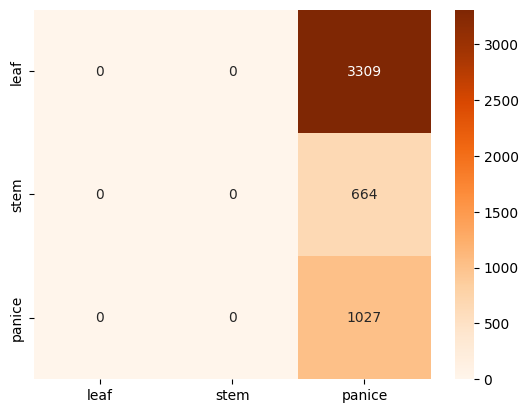

In [42]:
import seaborn as sn

#sn.set(font_scale=1.4) # for label size
#sn.color_palette("tab10")
sn.heatmap(test_confusion, cmap="Oranges", annot=True, fmt="d") # font size

plt.show()

### INFERENCE

SET testing point cloud

In [43]:
test_pointclouds = valid_pointclouds
test_pointclouds_labels = valid_pointclouds_labels

In [44]:
idx = 2
visualize_data(test_pointclouds[idx],test_pointclouds_labels[idx])

visualize_data(test_pointclouds[idx],pred_choice[idx].cpu().detach().numpy())

In [45]:
idx = 4
visualize_data(test_pointclouds[idx],test_pointclouds_labels[idx])

visualize_data(test_pointclouds[idx],pred_choice[idx].cpu().detach().numpy())